<a href="https://colab.research.google.com/github/geoffcorvera/deeplearning-spring2021/blob/hw4/Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

import matplotlib.pyplot as plt 

# Parameters
We load the VGG16 model (pretrained on the ImageNet dataset). The last convolutional layer in this model is named "block5_conv3" (run model.summary() to view layers of network). We define store the dimensions that input images need to be (224x224), and the path to our test files.

In [62]:
model = VGG16(weights='imagenet')
last_conv_name = 'block5_conv3'

target_size = (224,224)
img_dir = r'/content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/prog4_data'
filenames = ['gc1.jpg', 'gc2.jpg', 'gc3.jpg', 'gc4.jpg', 'gc5.jpg']

In [63]:
def preprocess_image(ipath, isize):
    # load_image returns a PIL image resized to (224,224)
    img = keras.preprocessing.image.load_img(ipath, target_size=isize)
    # convert to 3D numpy array
    im_arr = keras.preprocessing.image.img_to_array(img)
    # preprocess as per VGG16
    im_arr = preprocess_input(im_arr)
    # add dim to turn into batch of size 1
    im_arr = np.expand_dims(img, axis=0)
    return im_arr

# Display Top 3 Predictions
We run model.predict() on a test image and use the decode_predictions function from the VGG16 module to display the top three predicted classes the model made.

In [64]:
def top_preds_desc(preds):
  s = f"Top {len(preds)} predictions:"
  for (i, (desc, score)) in enumerate(preds):
    s += f"\n{i+1}) {desc} (Score: {score:.4f})"
  return s

def get_top3_preds(preds):
  decoded = decode_predictions(preds, top=3)[0]
  return [tuple(pred[1:]) for pred in decoded]

In [65]:
preprocessed_imgs = [preprocess_image(f'{img_dir}/{fname}', target_size) for fname in filenames]
top3_preds = [get_top3_preds(model.predict(img)) for img in preprocessed_imgs]

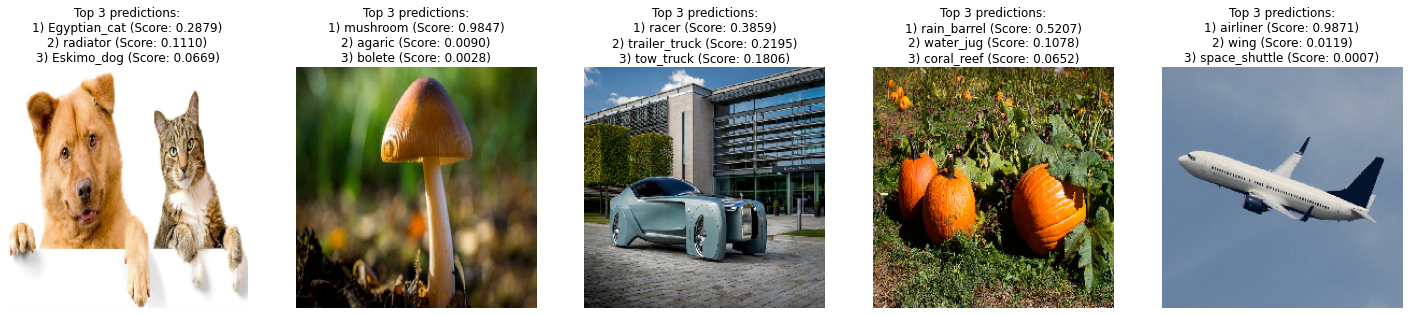

In [66]:
n_images = len(preprocessed_imgs)
fig, axs = plt.subplots(ncols=n_images, figsize=(25,20))
for (ax, img, top3) in zip(fig.axes, preprocessed_imgs, top3_preds):
  ax.axis('off')
  ax.set_title(top_preds_desc(top3))
  ax.imshow(img[0])

plt.show()

# Create Heatmaps
We use gradient weighted class activation maps to create heatmaps that highlight the portions of the input image that contributed the most to a specified classification. We create a Model for mapping the input image, to activations of the final convolutional layer and final predictions, so that Tensorflow.GradientTape can be used to calculate the gradients of a specified class channel with respect to the activations of the last conv layer. The average value of the gradient across a 14x14 feature map is calculated for each feature map. The pooled gradients measure the "importance" of a feature map to a given class channel. These importance values are the weights for a weighted sum of all the feature map activations - which is followed by a RELU to yield a coarse heatmap of the regions of the input image which contributed to a given classification.

The generated heatmaps will be the same size as the kernels in the final convolutional layer (14 x 14 for VGG16). The Grad-CAM heatmaps are resized to input image size. 

In [67]:
# From Stack Overflow post: https://stackoverflow.com/questions/58322147/how-to-generate-cnn-heatmaps-using-built-in-keras-in-tf2-0-tf-keras
def grad_cam(image, model, last_conv_name, score_to_match=None):
  last_layer = model.get_layer(last_conv_name)
  # Create a multi-output model that maps input image to activations of the 
  # last conv layer & the output predictions
  heatmap_model = keras.models.Model(
      inputs=[model.inputs],
      outputs=[last_layer.output, model.output]
  )

  # Calc the gradient of a class prediction for input image wrt last conv activations
  with tf.GradientTape() as gtape:
    conv_output, predictions = heatmap_model(image)

    if (score_to_match == None):
      p_index = tf.argmax(predictions[0])
    else:
      p_index = tf.where(tf.equal(predictions[0], tf.constant(score_to_match)))
      p_index = p_index.numpy().squeeze()
    
    class_channel = predictions[:, p_index]

    # Gradient of a specific class neuron wrt activations/feature maps of last conv layer
    grads = gtape.gradient(class_channel, conv_output)
    # Each element in this vector is the mean intensity of the gradient over a specific feature map channel
    importance_weights = tf.reduce_mean(grads, axis=(0,1,2))

  # Calc the weighted sum of each feature map channel (weighted by importance_weights)
  # wrt the top predicted class
  activations = conv_output[0]
  heatmap = activations @ importance_weights[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)
  # Apply ReLU and scale values for display
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy()

In [68]:
all_heatmaps = []
for img, top3 in zip(preprocessed_imgs, top3_preds):
  all_heatmaps.append([(desc, grad_cam(img, model, last_conv_name, score)) for desc, score in top3])

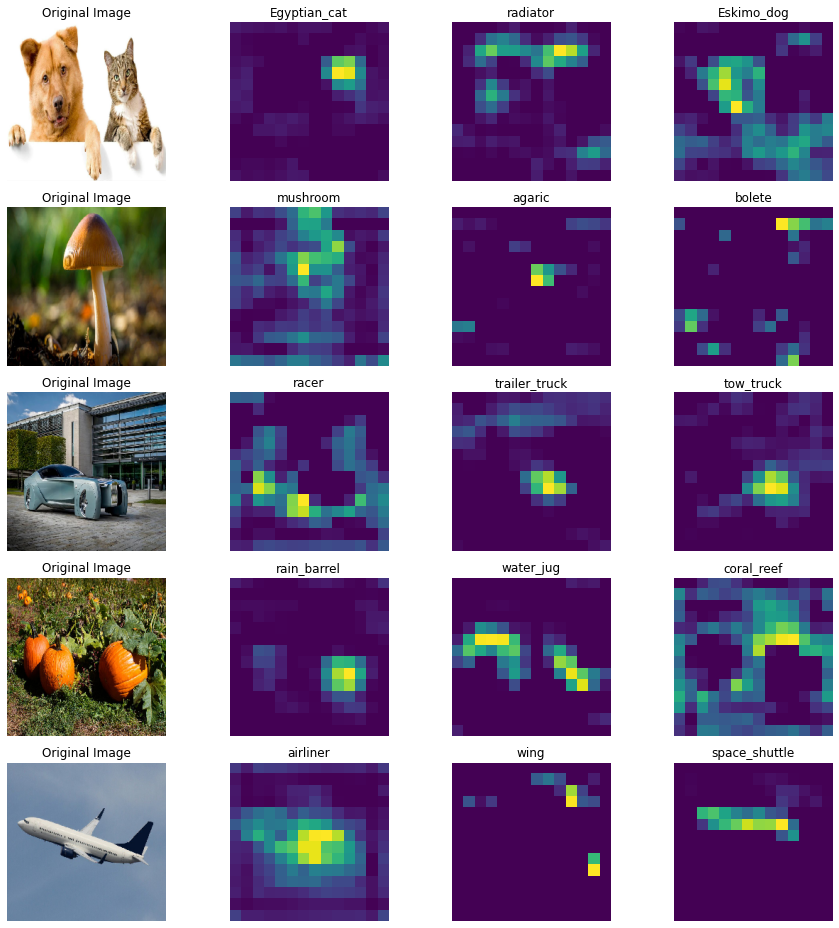

In [69]:
fig, axs = plt.subplots(n_images, 4, figsize=(13,13))
for row, im, maps in zip(axs, preprocessed_imgs, all_heatmaps):
  for ax, (desc, mat) in zip(row, [('Original Image' ,im[0])] + maps):
    ax.set_title(desc)
    ax.axis('off')
    ax.imshow(mat)

fig.tight_layout()
plt.show()

In [70]:
def resize_and_rescale_intensities(matrix, shape):
  # Add 'batch' and 'channels' dimensions
  res = matrix[tf.newaxis, ..., tf.newaxis]
  res = tf.image.resize(res, (shape[0], shape[1])).numpy()
  res = res.squeeze()
  return np.uint8(255 * res)

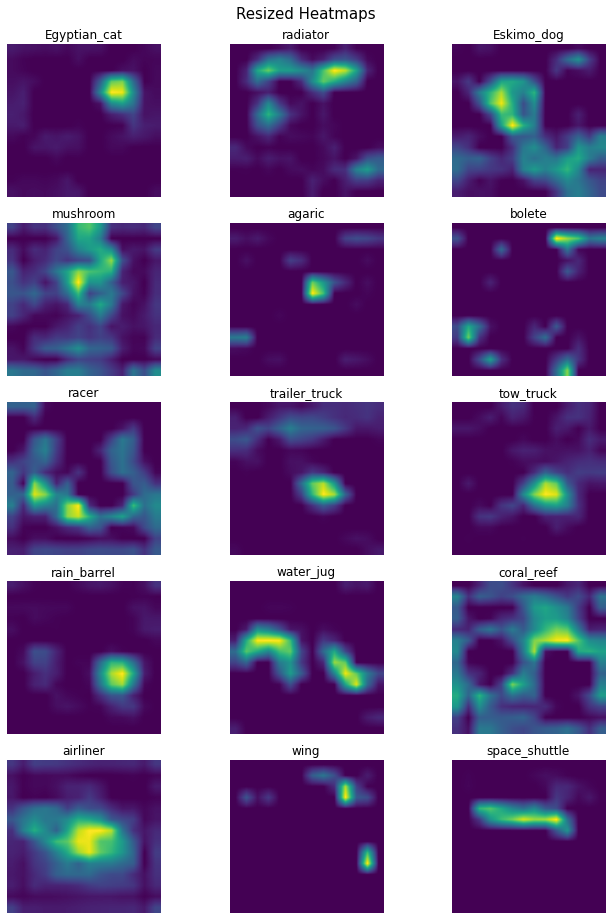

In [71]:
resized = [[(d, resize_and_rescale_intensities(m, target_size)) for d, m in row] for row in all_heatmaps]

fig, axs = plt.subplots(n_images, 3, figsize=(10,13))
for row, maps in zip(axs, resized):
  for ax, (desc, map) in zip(row, maps):
    ax.set_title(desc)
    ax.axis('off')
    ax.imshow(map)

fig.tight_layout()
fig.subplots_adjust(top=0.94)
plt.suptitle('Resized Heatmaps', fontsize=15)
plt.show()

resized = [[hmap for _, hmap in r] for r in resized]

# Superimpose Heatmaps & Images
The heatmaps are resized to match the input image size (via bi-linear interpolation), then are superimposed over the input image. The plots of the superimposed images highlight the regions of the original image which contributed to a specific prediction. The visual features highlighted in the images produced feature activations that contributed the most to the activation of a specified output neuron.

The heatmaps provide a way of seeing how the network reaches its conclusions. In images with multiple subjects (e.g. cat & dog), we can see that the network is able to identify faces and descriminiate between the two types of animals despite the lower confidence scores. When the network makes a "confident" prediction, we can see why. For example, the mushroom and airplane results below, show higher activation across the majority of the subject and little sensitivity to background features. The visualizations also provide explanations to how networks misclassify images. For example, the overall shape of the pumpkins are confused with rain barrels and water jugs, while the texture in the background is confused with coral reef textures. These observations can be useful for identifying failure modes & direct future efforts to improving the system or training dataset.

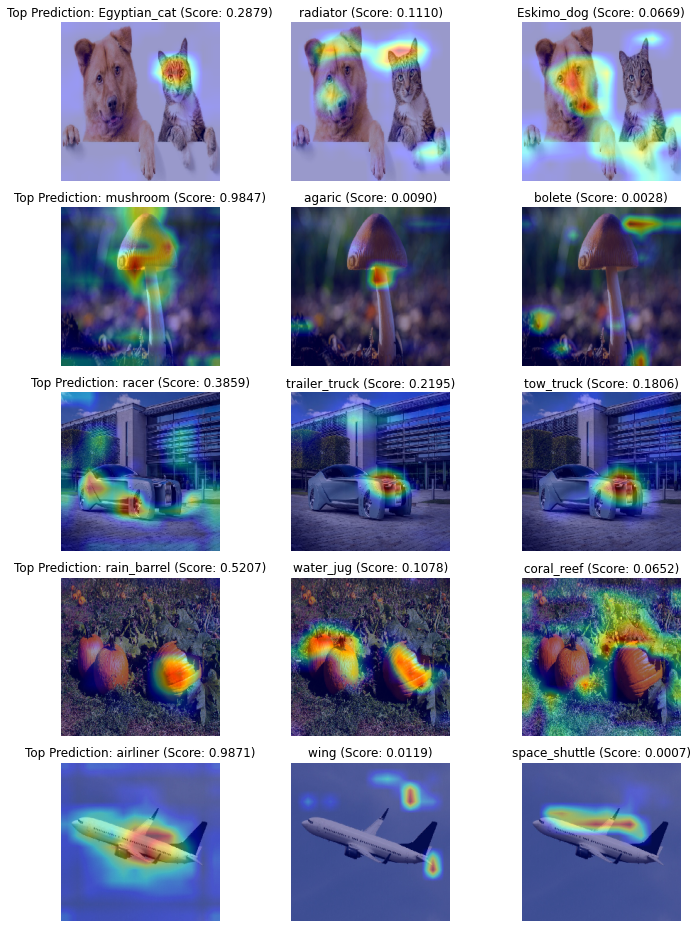

In [72]:
fig, axs = plt.subplots(nrows=n_images, ncols=3, figsize=(10,13))

assert axs.shape[0] == len(preprocessed_imgs)
for (row, heat_row, img, top3) in zip(axs, resized, preprocessed_imgs, top3_preds):
  for (i, ax, heatmap, (desc, score)) in zip(range(3), row, heat_row, top3):
    title = f"Top Prediction: {desc}" if (i == 0) else desc
    title += f" (Score: {score:.4f})"
    
    ax.imshow(img.squeeze())
    ax.imshow(heatmap, cmap='jet', alpha=0.4)
    ax.axis('off')
    ax.set_title(title)

plt.tight_layout()
plt.show()